# 1. Time Series Decomposition

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [1]:
!wget https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv -P datasets/

--2024-11-29 00:18:26--  https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5279 (5.2K) [text/plain]
Saving to: ‘datasets/example_retail_sales.csv’

example_retail_sale 100%[===================>]   5.16K  --.-KB/s    in 0s      

2024-11-29 00:18:26 (26.8 MB/s) - ‘datasets/example_retail_sales.csv’ saved [5279/5279]



## 1-1. Log Transform

## 1-2. Box-Cox Transform

## 1-3. Classical Decomposition
### 1-3-1. Classical Decomposition with pandas

In [4]:
df = pd.read_csv("datasets/example_retail_sales.csv", parse_dates=["ds"], index_col=["ds"])
df.head()

,y
ds,
1992-01-01,146376
1992-02-01,147079
1992-03-01,159336
1992-04-01,163669
1992-05-01,170068


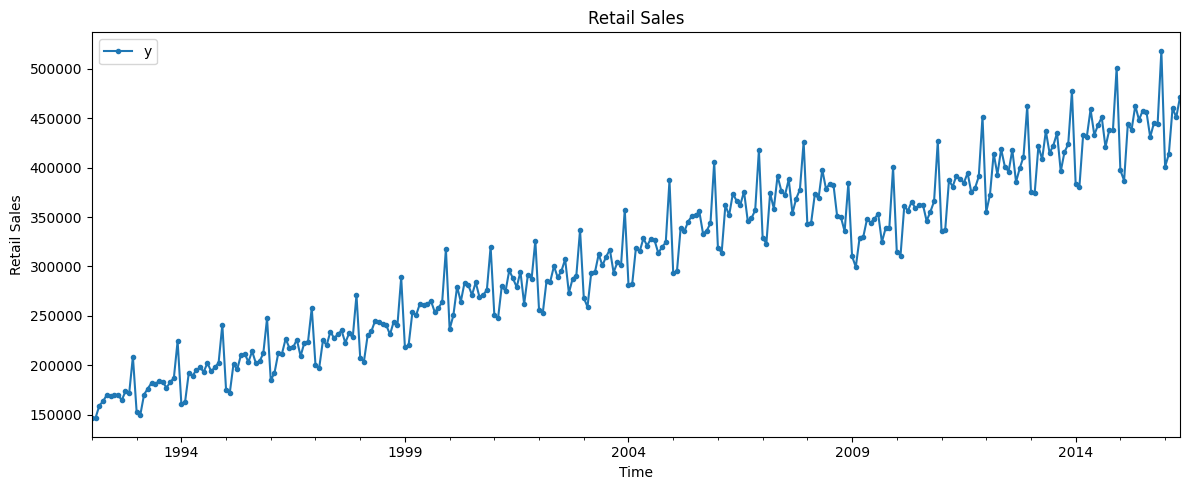

In [5]:
fig, ax = plt.subplots(figsize=[12, 5])

df.plot(ax=ax, marker=".")
ax.set_xlabel("Time")
ax.set_ylabel("Retail Sales")
ax.set_title("Retail Sales")
plt.tight_layout()

In [6]:
# Compute trend
window_size = 12
df["trend"] = (
    df.rolling(window=window_size)
    .mean()  # Apply the 12-MA without a centered window
    # The average is computed at the end of the window
    .rolling(window=2)
    .mean()  # Apply the 2-MA without a centred window
    # The average is computed at the end of the window
    .shift(-window_size // 2)  # Shift is required to align the 2x4-MA to what a
    # centered window would have produced
    # Integer division is used as shift() requires an int
)

In [7]:
# De-trend
df["y_detrended"] = df["y"] - df["trend"]
df.head()

,y,trend,y_detrended
ds,,,
1992-01-01,146376,NaN,NaN
1992-02-01,147079,NaN,NaN
1992-03-01,159336,NaN,NaN
1992-04-01,163669,NaN,NaN
1992-05-01,170068,NaN,NaN


In [8]:
# Average over each month
df["month"] = df.index.month
df.head()

,y,trend,y_detrended,month
ds,,,,
1992-01-01,146376,NaN,NaN,1
1992-02-01,147079,NaN,NaN,2
1992-03-01,159336,NaN,NaN,3
1992-04-01,163669,NaN,NaN,4
1992-05-01,170068,NaN,NaN,5


In [9]:
seasonality = df.groupby("month").mean()["y_detrended"]
seasonality.name = "seasonality"
seasonality

month
1    -31085.898551
2    -32941.297101
3      3032.637681
4     -2933.978261
5     13554.688406
6      4457.835145
7      4140.364583
8     10267.178819
9    -11945.057292
10    -3233.472222
11    -1135.296875
12    47751.626812
Name: seasonality, dtype: float64

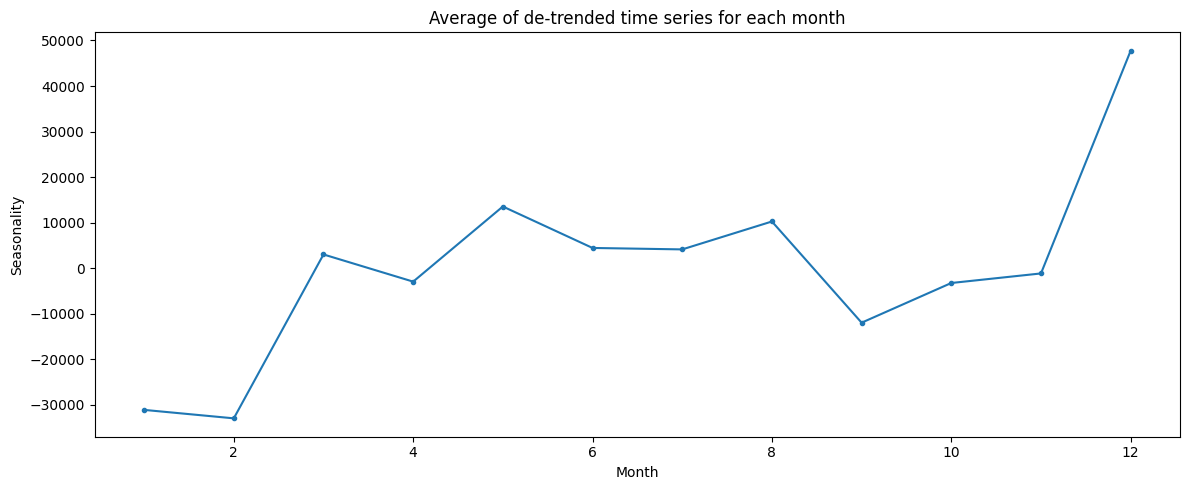

In [10]:
fig, ax = plt.subplots(figsize=[12, 5])
seasonality.plot(y="seasonality", ax=ax, marker=".")
ax.set_xlabel("Month")
ax.set_ylabel("Seasonality")
ax.set_title("Average of de-trended time series for each month")
plt.tight_layout()

In [11]:
df = df.merge(right=seasonality, left_on="month", right_index=True)
df = df.sort_index()
df.head()

,y,trend,y_detrended,month,seasonality
ds,,,,,
1992-01-01,146376,NaN,NaN,1,-31085.898551
1992-02-01,147079,NaN,NaN,2,-32941.297101
1992-03-01,159336,NaN,NaN,3,3032.637681
1992-04-01,163669,NaN,NaN,4,-2933.978261
1992-05-01,170068,NaN,NaN,5,13554.688406


In [13]:
df["residual"] = df["y"] - df["trend"] - df["seasonality"]
df.head()

,y,trend,y_detrended,month,seasonality,residual
ds,,,,,,
1992-01-01,146376,NaN,NaN,1,-31085.898551,NaN
1992-02-01,147079,NaN,NaN,2,-32941.297101,NaN
1992-03-01,159336,NaN,NaN,3,3032.637681,NaN
1992-04-01,163669,NaN,NaN,4,-2933.978261,NaN
1992-05-01,170068,NaN,NaN,5,13554.688406,NaN


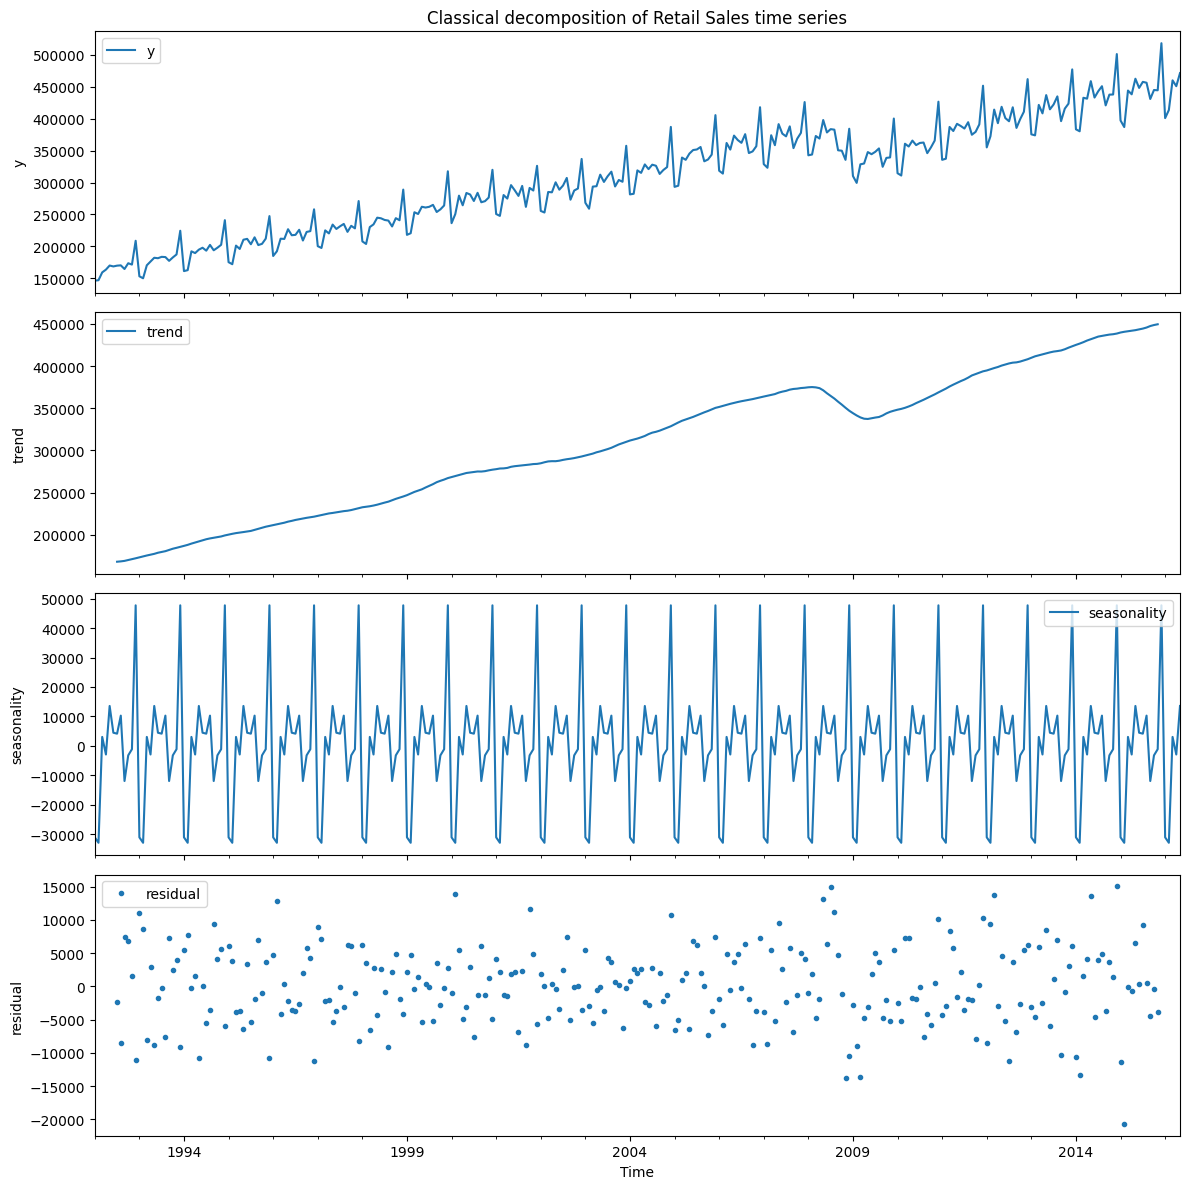

In [14]:
fig, ax = plt.subplots(nrows=4, figsize=[12, 12], sharex=True)

df["y"].plot(ax=ax[0], legend="y")
ax[0].set_ylabel("y")

df["trend"].plot(ax=ax[1], legend="trend")
ax[1].set_ylabel("trend")

df["seasonality"].plot(ax=ax[2], legend="seasonality")
ax[2].set_ylabel("seasonality")

df["residual"].plot(ax=ax[3], marker=".", legend="residual", ls="None")
ax[3].set_ylabel("residual")

ax[0].set_title("Classical decomposition of Retail Sales time series")
ax[3].set_xlabel("Time")

plt.tight_layout()

### 1-3-2. Classical Decomposition with statsmodels

In [15]:
res = seasonal_decompose(x=df["y"], model="additive", period=12)
res.trend.head(10)

ds
1992-01-01              NaN
1992-02-01              NaN
1992-03-01              NaN
1992-04-01              NaN
1992-05-01              NaN
1992-06-01              NaN
1992-07-01    168127.041667
1992-08-01    168537.583333
1992-09-01    169125.541667
1992-10-01    170120.958333
Name: trend, dtype: float64

In [17]:
res.seasonal.head(10)

ds
1992-01-01   -31080.009479
1992-02-01   -32935.408030
1992-03-01     3038.526752
1992-04-01    -2928.089190
1992-05-01    13560.577477
1992-06-01     4463.724216
1992-07-01     4146.253655
1992-08-01    10273.067891
1992-09-01   -11939.168220
1992-10-01    -3227.583151
Name: seasonal, dtype: float64

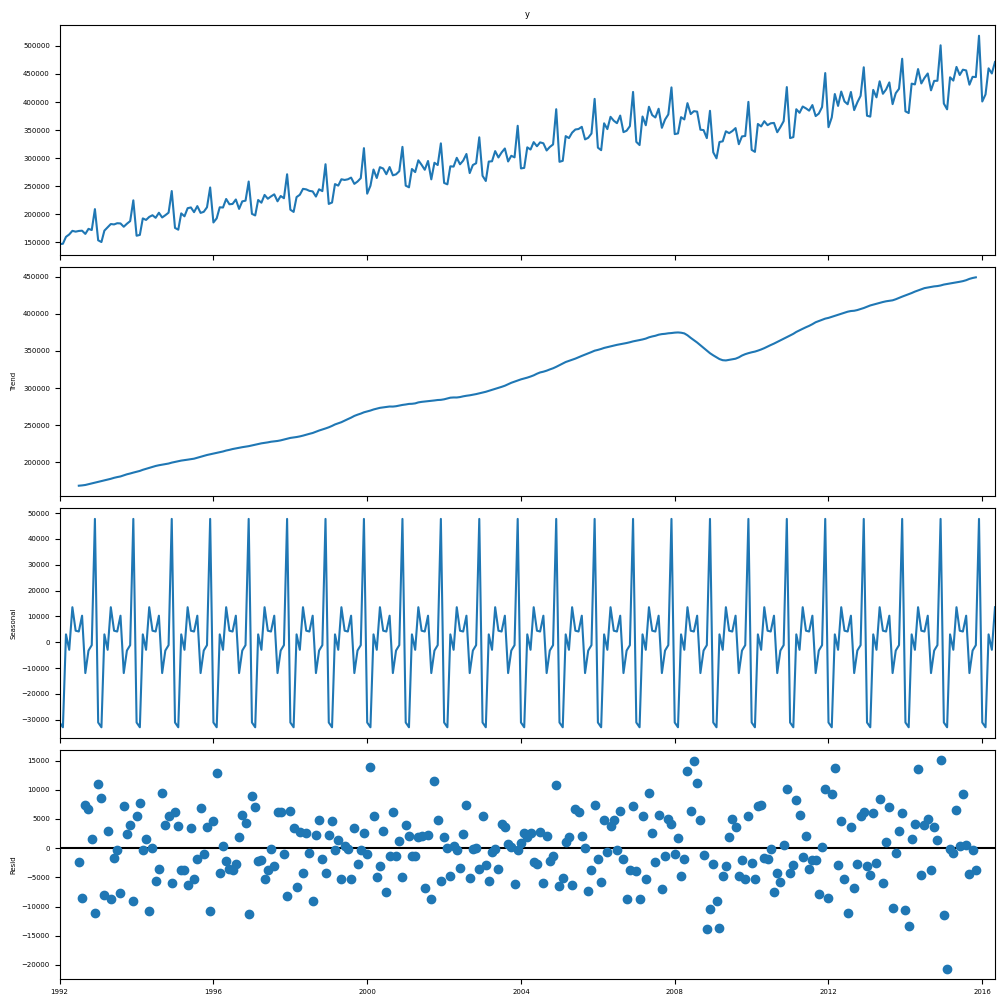

In [18]:
plt.rc("figure", figsize=(10, 10))
plt.rc("font", size=5)
res.plot();

## 1-4. LOWESS

## 1-5. STL